# MTRN4110 Phase D - Pathfinder (Group 20)

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # Matplotlib library for plotting
import subprocess
import os
import platform
import time
import sys

MAZE_FILE_NAME = '../Maze.png'
ROBOT_FILE_NAME = '../Robot.png'
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME = '../Map.txt'
WORLD_FILE_NAME = "../worlds/PhaseD.wbt"
RECORDING_FILE_NAME = "../RobotRecording.mp4"
MOTION_TRACKING_FILE_NAME = "../RobotMotionTracking.mp4"

THRESHOLD = 100

# Process Section of Image
def process_section(section, min_range, max_range):
    mask = cv2.inRange(section, min_range, max_range)
    masking = cv2.bitwise_and(section, section, mask=mask)
    kernel = np.ones((5,5), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Mark cornerstones on image
def mark_cornerstone(opening, maze_rgb, position, colour):
    # Referenced from https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html
    # Detect edges using Canny
    canny = cv2.Canny(opening, THRESHOLD, THRESHOLD * 2)
    
    # Find contours
    _, contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Approximate contours to polygons + get circles
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for idx, x in enumerate(contours):
        centers[idx], radius[idx] = cv2.minEnclosingCircle(cv2.approxPolyDP(x, 3, True))
    
    coord = None
    # Draw polygonal contour + circles
    for i in range(len(contours)):
        coord = (int(centers[i][0]) + position[0], int(centers[i][1]) + position[1])
        cv2.circle(maze_rgb, coord, int(radius[i]), colour, 2)
    
    return list(coord), maze_rgb

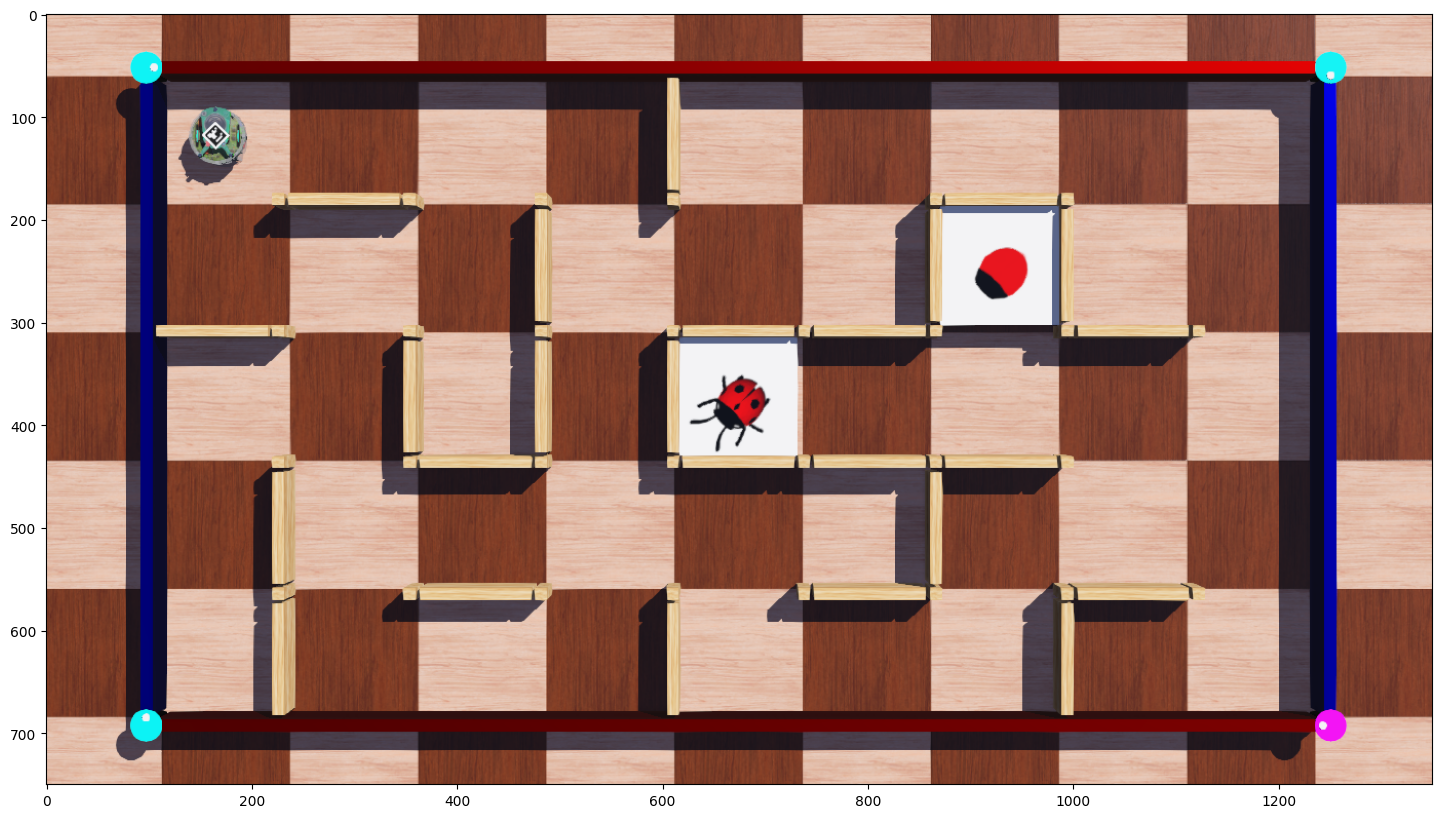

In [39]:
if __name__ == '__main__':
    maze_img = cv2.imread(MAZE_FILE_NAME)
    maze_hsv = cv2.cvtColor(maze_img, cv2.COLOR_BGR2HSV)
    maze_rgb = cv2.cvtColor(maze_img, cv2.COLOR_BGR2RGB)
    maze_gray = cv2.cvtColor(maze_img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize = (18, 10))
    plt.imshow(maze_rgb)
    plt.show()

## Find the four ordered cornerstones of the maze

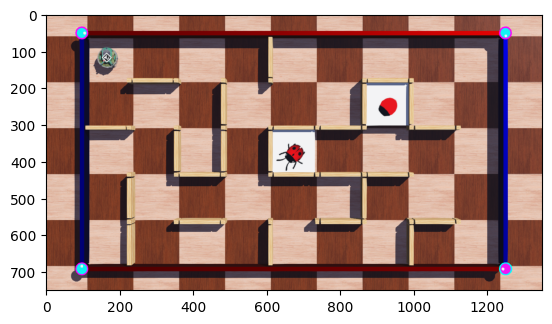

In [40]:
# Get cornerstone sections and create a mask (Cyan as 180 100 100 and Pink as 300, 100, 100)
section_A = maze_hsv[0:375, 0:338]
section_B = maze_hsv[0:375, 1012:1350]
section_C = maze_hsv[375:750, 0:338]
section_D = maze_hsv[375:750, 1012:1350]

opening_A = process_section(section_A, (85, 100, 20), (95, 255, 255))
opening_B = process_section(section_B, (85, 100, 20), (95, 255, 255))
opening_C = process_section(section_C, (85, 100, 20), (95, 255, 255))
opening_D = process_section(section_D, (85, 100, 20), (95, 255, 255))

# Check if section A or D is pink cornerstone by seeing if array has only 0's
pink_A = False
if np.any(opening_A):
    opening_D = process_section(section_D, (145, 100, 20), (155, 255, 255))
    pink_A = False
else:
    opening_A = process_section(section_A, (145, 100, 20), (155, 255, 255))
    pink_A = True
    
# Mark the cornerstones and get the coordinates
coord_A = None
coord_D = None
if pink_A:
    coord_A, maze_rgb = mark_cornerstone(opening_A, maze_rgb, (0, 0), (0, 255, 255))
    coord_D, maze_rgb = mark_cornerstone(opening_D, maze_rgb, (1012, 375), (255, 0, 255))
else:
    coord_A, maze_rgb = mark_cornerstone(opening_A, maze_rgb, (0, 0), (255, 0, 255))
    coord_D, maze_rgb = mark_cornerstone(opening_D, maze_rgb, (1012, 375), (0, 255, 255))
coord_B, maze_rgb = mark_cornerstone(opening_B, maze_rgb, (1012, 0), (255, 0, 255))
coord_C, maze_rgb = mark_cornerstone(opening_C, maze_rgb, (0, 375), (255, 0, 255))
    
# Show in a window
plt.imshow(maze_rgb)
plt.show()

## Perspective transform the maze from the original image to a rectangle image

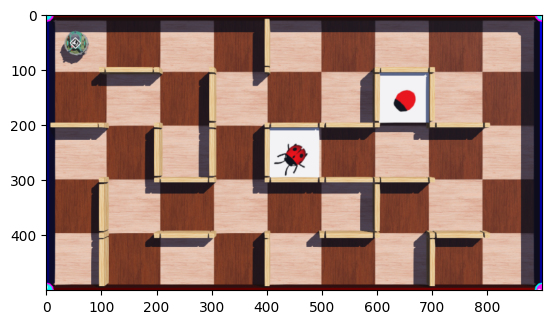

In [41]:
# Perspective transform the maze into 900x500
pts1 = None
pts2 = np.float32([[0,0],[900,0],[0,500],[900,500]])
if pink_A:
    pts1 = np.float32([coord_D, coord_C, coord_B, coord_A])
else:
    pts1 = np.float32([coord_A, coord_B, coord_C, coord_D])

H = cv2.getPerspectiveTransform(pts1, pts2)
    
fixed_maze_hsv = cv2.warpPerspective(maze_hsv, H, (900,500))
fixed_maze_rgb = cv2.warpPerspective(maze_rgb, H, (900,500))
    
plt.imshow(fixed_maze_rgb)
plt.show()

## Detect all the internal walls

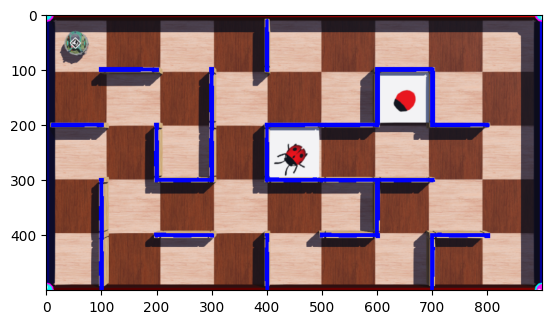

In [42]:
# Detect and indicate internal walls
mask = cv2.inRange(fixed_maze_hsv, (15, 73, 220), (25, 110, 255))
wall_RGB = cv2.bitwise_and(fixed_maze_rgb, fixed_maze_rgb, mask = mask)

wall_GRAY = cv2.cvtColor(wall_RGB, cv2.COLOR_RGB2GRAY)
kernel = np.ones((3,3), np.uint8)
wall_closing = cv2.morphologyEx(wall_GRAY, cv2.MORPH_CLOSE, kernel, iterations = 8)
wall_opening = cv2.morphologyEx(wall_closing, cv2.MORPH_OPEN, kernel)
walls = wall_opening

maze_walls = np.nonzero(walls)
fixed_maze_rgb[maze_walls] = [0,0,255]

plt.imshow(fixed_maze_rgb)
plt.show()

## Detect the location and heading of the robot

In [43]:
# Find location of robot picture to the maze with template matching
robot_img = cv2.imread(ROBOT_FILE_NAME)
robot_rgb = cv2.cvtColor(robot_img, cv2.COLOR_BGR2RGB)
robot_gray = cv2.cvtColor(robot_img, cv2.COLOR_BGR2GRAY)
canny_maze = cv2.Canny(maze_gray, THRESHOLD, THRESHOLD * 2)

best_fit = None
# Referenced from https://pyimagesearch.com/2015/01/26/multi-scale-template-matching-using-python-opencv/
# Set scales to between 7.5 and 12 with spacing of 0.05 (i.e robot in closeup is between 100px and 62.5px)
for scale in np.linspace(7.5, 12, 91):
    # Resize the image to try and match the one in maze
    size = int(750/scale)
    resized_robot = cv2.resize(robot_gray, (size, size))

    # Use TemplateMatching and determine min/max value
    canny_robot = cv2.Canny(resized_robot, THRESHOLD, THRESHOLD * 2)
    result = cv2.matchTemplate(canny_maze, canny_robot, cv2.TM_CCOEFF)
    (_, max_val, _, max_loc) = cv2.minMaxLoc(result)
    
    # If this scale has a better correlation, update best fit
    if best_fit is None or max_val > best_fit[0]:
        best_fit = (max_val, max_loc, scale)
        
# Get best fit values
_, max_loc, r = best_fit

(start_x, start_y) = (max_loc[0], max_loc[1])

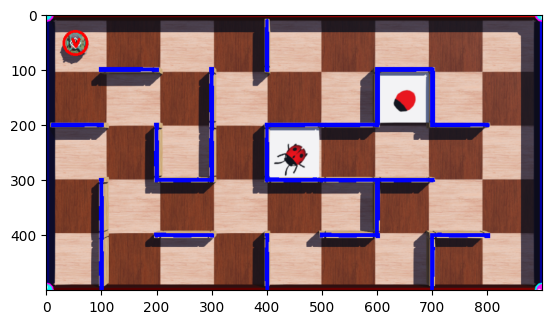

In [44]:
# Detect ArUco marker for centre
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
parameters =  cv2.aruco.DetectorParameters_create()
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_rgb, dictionary, parameters=parameters)

aruco = markerCorners[0][0]
# Centre is the average of all co-ordinates
x = (aruco[0][0]+aruco[1][0]+aruco[2][0]+aruco[3][0])/4
y = (aruco[0][1]+aruco[1][1]+aruco[2][1]+aruco[3][1])/4
# Find position in reference to maze
scaled_x = start_x + x / r
scaled_y = start_y + y / r
# Heading of robot is centre to top-left corner
heading_x = start_x + aruco[0][0] / r
heading_y = start_y + aruco[0][1] / r

# Transform point to find fixed position on fixed maze
true_pos = np.array([[[scaled_x,scaled_y],[heading_x,heading_y]]], dtype = "float32")
fixed_pos = cv2.perspectiveTransform(true_pos,H)

centre_coords = (int(fixed_pos[0][0][0]),int(fixed_pos[0][0][1]))
heading_coords = (int(fixed_pos[0][1][0]),int(fixed_pos[0][1][1]))

# Determine heading by checking direction from centre to heading (N,E,S,W)
heading = None
if (centre_coords[1] - 15) <= heading_coords[1] <= (centre_coords[1] - 5) and (centre_coords[0] - 2) <= heading_coords[0] <= (centre_coords[0] + 2):
    heading = '^'
    a = -10
    b = 9
elif (centre_coords[0] + 5) <= heading_coords[0] <= (centre_coords[0] + 15) and (centre_coords[1] - 2) <= heading_coords[1] <= (centre_coords[1] + 2):
    heading = '>'
    a = -9
    b = 9
elif (centre_coords[1] + 5) <= heading_coords[1] <= (centre_coords[1] + 15) and (centre_coords[0] - 2) <= heading_coords[0] <= (centre_coords[0] + 2):
    heading = 'v'
    a = -7
    b = 7
elif (centre_coords[0] - 15) <= heading_coords[0] <= (centre_coords[0] - 5) and (centre_coords[1] - 2) <= heading_coords[1] <= (centre_coords[1] + 2):
    heading = '<'
    a = -13
    b = 9

heading_size, _ = cv2.getTextSize(heading, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 3)
heading_coords = (int(centre_coords[0] - heading_size[0] / 2), int(centre_coords[1] + heading_size[1] / 2))

cv2.circle(fixed_maze_rgb, centre_coords, 21, (255,0,0), 3)
cv2.putText(fixed_maze_rgb, heading, (centre_coords[0] + a, centre_coords[1] + b), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3)
plt.imshow(fixed_maze_rgb)
plt.show()

## Detect the position of the true target

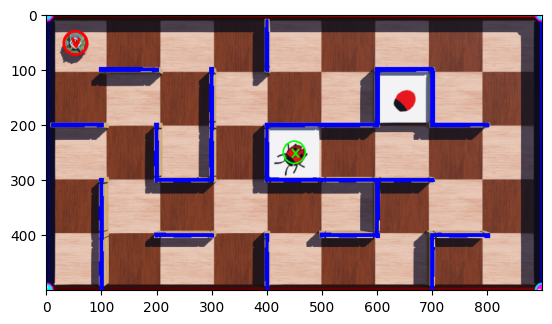

In [46]:
# using SIFT 
ladybug = cv2.imread(IMAGE_LADYBUG_FILE_NAME)
ladybug_rgb = cv2.cvtColor(ladybug, cv2.COLOR_BGR2RGB)
ladybug_hsv = cv2.cvtColor(ladybug, cv2.COLOR_BGR2HSV)

mask_lower = np.array([0, 0, 245])
mask_upper = np.array([0, 5, 255])
ladybug_mask = cv2.inRange(ladybug_hsv, mask_lower, mask_upper)
ladybug_mask = cv2.morphologyEx(ladybug_mask, cv2.MORPH_CLOSE, iterations=3, kernel=np.ones((10, 10), np.uint8))

img1 = fixed_maze_rgb # query image
img2 = ladybug_rgb # train image

# Initiate SIFT detector
sift  = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None) # maze
kp2, des2 = sift.detectAndCompute(img2, None) # ladybug

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# Match descriptors
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# get position of all the matches
# https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
x_kp1 = []
y_kp1 = []

for index, match in enumerate(matches):
    # Get the matching keypoints for each of the images
    img_idx = match.queryIdx
    (x, y) = kp1[img_idx].pt

    # Append to each list
    x_kp1.append(x)
    y_kp1.append(y)

    # ensure only first 11 match coordinates are stored
    if index == 10:
        break

# average match coordinates
x_target = int(np.average(x_kp1))
y_target = int(np.average(y_kp1))
ladybug_coords = (x_target, y_target)

x_cell = 50 * round(x_target/50)
y_cell = 50 * round(y_target/50)
ladybug_cell = (int(x_cell), int(y_cell))

fixed_maze_rgb = cv2.putText(fixed_maze_rgb, "x", (x_target + 7, y_target - 7), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
cv2.circle(fixed_maze_rgb, ladybug_cell, radius=20, color=(0,255,0), thickness=2)

plt.imshow(fixed_maze_rgb)
plt.show()



## Generate a map and write it to a text file

In [47]:
Map = [' --- --- --- --- --- --- --- --- --- \n',
       '|                                   |\n',
       '                                     \n',
       '|                                   |\n',
       '                                     \n',
       '|                                   |\n',
       '                                     \n',
       '|                                   |\n',
       '                                     \n',
       '|                                   |\n',
       ' --- --- --- --- --- --- --- --- --- ']

# Check 30x30 square for blue pixels where the wall would exist
# Place walls in map string if they exist
for i in range(5):
    for j in range(8):
        x = 100 * (j + 1)
        y = 100 * i + 50
        section = fixed_maze_rgb[y - 15: y + 15, x - 15: x + 15]
        mask = cv2.inRange(section, (0, 0, 255), (0, 0, 255))
        if np.any(mask):
            map_row = 2 * i + 1
            map_col = 4 * j + 4
            Map[map_row] = Map[map_row][:map_col] + '|' + Map[map_row][map_col + 1:]
            
for i in range(4):
    for j in range(9):
        x = 100 * j + 50
        y = 100 * (i + 1)
        section = fixed_maze_rgb[y - 15: y + 15, x - 15: x + 15]
        mask = cv2.inRange(section, (0, 0, 255), (0, 0, 255))
        if np.any(mask):
            map_row = 2 * (i + 1)
            map_col = 4 * j + 1
            Map[map_row] = Map[map_row][:map_col] + '---' + Map[map_row][map_col + 3:]

centre_row = 2 * int(centre_coords[1]/100) + 1
centre_col = 4 * int(centre_coords[0]/100) + 2
Map[centre_row] = Map[centre_row][:centre_col] + heading + Map[centre_row][centre_col + 1:]

ladybug_row = 2 * int(ladybug_coords[1]/100) + 1
ladybug_col = 4 * int(ladybug_coords[0]/100) + 2
Map[ladybug_row] = Map[ladybug_row][:ladybug_col] + 'x' + Map[ladybug_row][ladybug_col + 1:]

with open(MAP_FILE_NAME, 'w') as infile:
    for line in Map:
        infile.write(line)

## Execute path planning and motion execution modules

In [48]:
# Check if any old versions of the recordings exist, if so delete them
if (os.path.exists(RECORDING_FILE_NAME)):
    os.remove(RECORDING_FILE_NAME)
if (os.path.exists(MOTION_TRACKING_FILE_NAME)):
    os.remove(MOTION_TRACKING_FILE_NAME)

# https://stackoverflow.com/questions/434597/open-document-with-default-os-application-in-python-both-in-windows-and-mac-os
# Note: This will not work if the user already has Webots open
# Open for macOS
if platform.system() == 'Darwin':       
    subprocess.call(('open', WORLD_FILE_NAME))
# Open for Windows
elif platform.system() == 'Windows':   
    os.startfile(WORLD_FILE_NAME)

# Wait till the new recording has been saved
while not os.path.exists(RECORDING_FILE_NAME):
    time.sleep(1)

## Extra features 1: Motion tracking from recorded simulation video

In [49]:
# Code adapted from: https://youtu.be/O3b8lVF93jU and lecture 8 code.

# Read video
video = cv2.VideoCapture(RECORDING_FILE_NAME)
# Video to save motion tracking frames
recording = cv2.VideoWriter(MOTION_TRACKING_FILE_NAME, cv2.VideoWriter_fourcc(*"MP4V"), 30, (800,600))

# Exit if video not opened.
if not video.isOpened():
    print("Could not open video")
    sys.exit()

# Read first frame.
ok, frame = video.read()
if not ok:
    print('Cannot read video file')
    sys.exit()

# Object detection from stable camera
object_detector = cv2.createBackgroundSubtractorMOG2()

while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break

    # Object detection
    mask = object_detector.apply(frame)
    # Remove any noise from shadows
    _, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)

    # Motion tracking
    _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Calculate area and remove noise
        area = cv2.contourArea(contour)
        if area > 500:
            x, y, width, height = cv2.boundingRect(contour)
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
    recording.write(cv2.resize(frame, (800,600)))

video.release()
recording.release()